这个demo中包含样本bbox的读取，预测结果，多模型结果集成，非极大值抑制，mAP值的评估

In [7]:
#这个头文件指的是精准的除法，就是会帮你把小数后面的数值都保留下来，不会去除。
from __future__ import division


%load_ext autoreload
%autoreload 2
import os
import torch as t
import numpy as np
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
%matplotlib inline
from collections import defaultdict
import itertools
import numpy as np
import six
from model.utils.bbox_tools import bbox_iou
import cv2

from data.dataset import Dataset, TestDataset, inverse_normalize
from torch.utils import data as data_
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
testset = TestDataset(opt)
dataloader = data_.DataLoader(testset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False,
                                   pin_memory=True
                                    )

In [9]:
#载入模型
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/usr/lib/python3/dist-packages/urllib3/util/connection.py", line 83, in create_connection
    raise err
  File "/usr/lib/python3/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 357, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.6/http/client.py", li

load caffe_pretrain_path
Exception in user code:
------------------------------------------------------------


In [10]:
opt.caffe_pretrain = True 
pred_bboxes, pred_labels, pred_scores = list(), list(), list()
gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_, id_) in tqdm(enumerate(dataloader)):
    sizes = [sizes[0][0].item(), sizes[1][0].item()]
    pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])


    gt_bboxes += list(gt_bboxes_.numpy())
    gt_labels += list(gt_labels_.numpy())
    gt_difficults += list(gt_difficults_.numpy())
    pred_bboxes += pred_bboxes_
    pred_labels += pred_labels_
    pred_scores += pred_scores_
    if ii == 10:
        break
    print(pred_bboxes_)
    print(pred_labels_)
    print(pred_scores_)
# print len(pred_bboxes)
# 这个评价函数是返回ap 和map值 其中传入的pred_bboxes格式为3维的数组的list格式，
# 也就是说每个list都是一个3维数组(有batch的考量)
# 其他的同理

0it [00:00, ?it/s]


IndexError: tuple index out of range

In [ ]:
result = eval_detection_voc(
    pred_bboxes, pred_labels, pred_scores,
    gt_bboxes, gt_labels, gt_difficults,
    use_07_metric=True)

You'll need to download pretrained model from [google dirve](https://drive.google.com/open?id=1cQ27LIn-Rig4-Uayzy_gH5-cW-NRGVzY) 
# 1. model converted from chainer

load own model


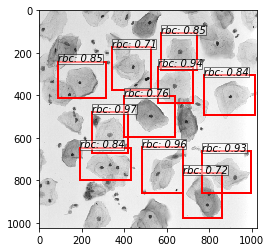

In [5]:
# in this machine the cupy isn't install correctly... 
# so it's a little slow
trainer.load('checkpoints/fasterrcnn_10171130_0.7809367386918437')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
# it failed to find the dog, but if you set threshold from 0.7 to 0.6, you'll find it

# 2. model trained with torchvision pretrained model

In [17]:
#加载权重
trainer.load('checkpoints/fasterrcnn_10030146_0.655118455807173')
opt.caffe_pretrain=True # this model was trained from torchvision-pretrained model
# _bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
# vis_bbox(at.tonumpy(img[0]),
#          at.tonumpy(_bboxes[0]),
#          at.tonumpy(_labels[0]).reshape(-1),
#          at.tonumpy(_scores[0]).reshape(-1))
pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(test_dataloader,trainer.faster_rcnn,test_num=500)
# print pred_bboxes1
result = eval_detection_voc(
        pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels,
        use_07_metric=True)
map_result=every_map(pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes,gt_labels,gt_difficults)
print result

load own model


500it [01:57,  4.24it/s]


(1100,)
{'ap': array([0.65740399, 0.60695187, 0.63268968, 0.41494713, 0.40909091,
       0.90909091, 0.68393737, 0.71449134, 0.25701816, 0.6002886 ,
       0.4418013 , 0.55591844, 0.7995338 , 0.56917706, 0.60392342,
       0.37895545, 0.77497305, 0.58455625, 0.60244108, 0.48947013]), 'map': 0.5843329959894726}


# 2. 寻找典型样本（map最高的100个）

In [21]:
opt.datatxt='1'
trainset = TestDataset(opt,split=opt.datatxt)
train_dataloader = data_.DataLoader(trainset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False,
                                   pin_memory=True
                                    )
pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(train_dataloader,trainer.faster_rcnn,test_num=1100)
map_result=every_map(pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes,gt_labels,gt_difficults)
# print map_result


0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:01,  1.35it/s]
3it [00:01,  1.74it/s]
4it [00:01,  2.05it/s]
5it [00:02,  2.28it/s]
6it [00:02,  2.47it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


7it [00:02,  2.60it/s]
8it [00:02,  2.76it/s]
9it [00:03,  2.86it/s]
10it [00:03,  2.97it/s]
11it [00:03,  3.04it/s]
12it [00:03,  3.11it/s]
13it [00:04,  3.18it/s]
14it [00:04,  3.23it/s]
15it [00:04,  3.29it/s]
16it [00:04,  3.34it/s]
17it [00:05,  3.38it/s]
18it [00:05,  3.42it/s]
19it [00:05,  3.45it/s]
20it [00:05,  3.47it/s]
21it [00:06,  3.50it/s]
22it [00:06,  3.53it/s]
23it [00:06,  3.55it/s]
24it [00:06

573it [02:08,  4.45it/s]
574it [02:09,  4.45it/s]
575it [02:09,  4.45it/s]
576it [02:09,  4.45it/s]
577it [02:09,  4.45it/s]
578it [02:09,  4.45it/s]
579it [02:10,  4.45it/s]
580it [02:10,  4.45it/s]
581it [02:10,  4.45it/s]
582it [02:10,  4.45it/s]
583it [02:11,  4.45it/s]
584it [02:11,  4.45it/s]
585it [02:11,  4.45it/s]
586it [02:11,  4.45it/s]
587it [02:11,  4.45it/s]
588it [02:12,  4.45it/s]
589it [02:12,  4.45it/s]
590it [02:12,  4.45it/s]
591it [02:12,  4.45it/s]
592it [02:12,  4.45it/s]
593it [02:13,  4.45it/s]
594it [02:13,  4.45it/s]
595it [02:13,  4.45it/s]
596it [02:13,  4.45it/s]
597it [02:14,  4.45it/s]
598it [02:14,  4.45it/s]
599it [02:14,  4.45it/s]
600it [02:14,  4.45it/s]
601it [02:14,  4.45it/s]
602it [02:15,  4.45it/s]
603it [02:15,  4.45it/s]
604it [02:15,  4.45it/s]
605it [02:15,  4.45it/s]
606it [02:16,  4.45it/s]
607it [02:16,  4.45it/s]
608it [02:16,  4.45it/s]
609it [02:16,  4.45it/s]
610it [02:16,  4.45it/s]
611it [02:17,  4.45it/s]
612it [02:17,  4.45it/s]


(1100,)


In [22]:
print map_result[100]

1.0000000000000002


In [23]:
print map_result
print len(ID)
def modify(datapath,map_result):
    order = map_result.argsort()[::-1]
    f = open(file+datapath, "a")
    for i in range(100):
        f.write(ID[order[i]]+'\n')
#         print ID[order[i]]
    f.close()

modify('2.txt',map_result)

[0.54545455 1.         1.         ... 0.         0.         0.        ]
1000


# 3. model trained with caffe pretrained model

In [15]:
trainer.load('checkpoints/fasterrcnn_10051345_0.6596131442448964')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
# vis_bbox(at.tonumpy(img[0]),
#          at.tonumpy(_bboxes[0]),
#          at.tonumpy(_labels[0]).reshape(-1),
#          at.tonumpy(_scores[0]).reshape(-1))
# pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(test_dataloader,trainer.faster_rcnn)
# result = eval_detection_voc(
#         pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels,
#         use_07_metric=True)
# # map_result=every_map(pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes,gt_labels,gt_difficults)
# print result

load own model


In [16]:
opt.datatxt='2'
trainset = TestDataset(opt,split=opt.datatxt)
train_dataloader = data_.DataLoader(trainset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False,
                                   pin_memory=True
                                    )
pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(train_dataloader,trainer.faster_rcnn,test_num=1100)
map_result=every_map(pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes,gt_labels,gt_difficults)
# print map_result

1100it [04:12,  4.36it/s]


(1100,)


In [17]:
print map_result
def modify(datapath,map_result):
    order = map_result.argsort()[::-1]
    f = open(file+datapath, "a")
    for i in range(100):
        f.write(ID[order[i]]+'\n')
#         print ID[order[i]]
    f.close()

modify('3.txt',map_result)

[0.77272727 0.         0.92929293 ... 1.         1.         1.        ]


In [ ]:
pred_bboxes_, pred_labels_, pred_scores_,result=nms_reuslt(pred_bboxes1, pred_labels1, pred_scores1, 
                                                    pred_bboxes_, pred_labels_, pred_scores_)
print result

In [15]:
#加载权重
trainer.load('checkpoints/fasterrcnn_10052349_0.6540336300676295')
opt.caffe_pretrain=True # this model was trained from torchvision-pretrained model
# _bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
# vis_bbox(at.tonumpy(img[0]),
#          at.tonumpy(_bboxes[0]),
#          at.tonumpy(_labels[0]).reshape(-1),
#          at.tonumpy(_scores[0]).reshape(-1))
# pred_bboxes1, pred_labels1, pred_scores1=bbox_result(test_dataloader,trainer.faster_rcnn)
# # print pred_bboxes1
# result = eval_detection_voc(
#         pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,
#         use_07_metric=True)
# print result

load own model


In [16]:
opt.datatxt='3'
trainset = TestDataset(opt,split=opt.datatxt)
train_dataloader = data_.DataLoader(trainset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False,
                                   pin_memory=True
                                    )
pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(train_dataloader,trainer.faster_rcnn,test_num=1100)
map_result=every_map(pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes,gt_labels,gt_difficults)
# print map_result
print map_result
def modify(datapath,map_result):
    order = map_result.argsort()[::-1]
    f = open(file+datapath, "a")
    for i in range(100):
        f.write(ID[order[i]]+'\n')
#         print ID[order[i]]
    f.close()

modify('4.txt',map_result)

1100it [04:10,  4.39it/s]


(1100,)
[0.27272727 1.         1.         ... 1.         1.         1.        ]


In [ ]:
pred_bboxes_, pred_labels_, pred_scores_,result=nms_reuslt(pred_bboxes1, pred_labels1, pred_scores1, 
                                                    pred_bboxes_, pred_labels_, pred_scores_)
print result

In [17]:
#加载权重
trainer.load('fasterrcnn_12222105_0.712649824453_caffe_pretrain.pth')
opt.caffe_pretrain=True # this model was trained from torchvision-pretrained model
# _bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
# vis_bbox(at.tonumpy(img[0]),
#          at.tonumpy(_bboxes[0]),
#          at.tonumpy(_labels[0]).reshape(-1),
#          at.tonumpy(_scores[0]).reshape(-1))

pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(test_dataloader,trainer.faster_rcnn)
result = eval_detection_voc(
        pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels,gt_difficults,
        use_07_metric=True)
# map_result=every_map(pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes,gt_labels,gt_difficults)
print result

load own model



0it [00:00, ?it/s]
1it [00:05,  5.10s/it]
2it [00:05,  2.69s/it]
3it [00:05,  1.86s/it]
4it [00:05,  1.45s/it]
5it [00:06,  1.21s/it]
6it [00:06,  1.04s/it]
7it [00:06,  1.08it/s]
8it [00:06,  1.19it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.39it/s]
11it [00:07,  1.48it/s]
12it [00:07,  1.57it/s]
13it [00:07,  1.65it/s]
14it [00:08,  1.72it/s]
15it [00:08,  1.80it/s]
16it [00:08,  1.88it/s]
17it [00:08,  1.94it/s]
18it [00:08,  2.00it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.12it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


21it [00:09,  2.17it/s]
22it [00:09,  2.22it/s]
23it [00:10,  2.27it/s]
24it [00:10

{'ap': array([0.7138352 , 0.76831169, 0.73873349, 0.70582272, 0.6305766 ,
       0.99586777, 0.8854334 , 0.81060606, 0.50042379, 0.73748353,
       0.58522727, 0.745788  , 0.81818182, 0.73471842, 0.76113709,
       0.4098616 , 0.85064027, 0.69730917, 0.82001962, 0.61684285]), 'map': 0.7263410180624329}


In [16]:
# pred_bboxes_, pred_labels_, pred_scores_,result=nms_reuslt(pred_bboxes1, pred_labels1, pred_scores1, 
#                                                     pred_bboxes_, pred_labels_, pred_scores_)
# print result

In [17]:
opt.datatxt='4'
trainset = TestDataset(opt,split=opt.datatxt)
train_dataloader = data_.DataLoader(trainset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False,
                                   pin_memory=True
                                    )
pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(train_dataloader,trainer.faster_rcnn,test_num=1100)
map_result=every_map(pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes,gt_labels,gt_difficults)
# print map_result
print map_result
def modify(datapath,map_result):
    order = map_result.argsort()[::-1]
    f = open(file+datapath, "a")
    for i in range(100):
        f.write(ID[order[i]]+'\n')
#         print ID[order[i]]
    f.close()

modify('5.txt',map_result)

1100it [04:04,  4.50it/s]


(1100,)
[1.         1.         0.92424242 ... 0.66666667 1.         0.54545455]


load own model


30it [00:07,  3.87it/s]Process Process-28:
Process Process-27:
Process Process-32:
Process Process-29:
Process Process-31:
Process Process-26:
Process Process-25:
Process Process-30:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "

KeyboardInterrupt: 

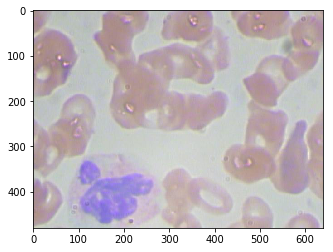

In [24]:
#加载权重
trainer.load('checkpoints/fasterrcnn_10072222_0.6705492503389949')
opt.caffe_pretrain=True # this model was trained from torchvision-pretrained model
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,ID=bbox_result(test_dataloader,trainer.faster_rcnn)
# print pred_bboxes1
result = eval_detection_voc(
        pred_bboxes1, pred_labels1, pred_scores1,gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
print result

In [23]:
pred_bboxes_, pred_labels_, pred_scores_,result=nms_reuslt(pred_bboxes1, pred_labels1, pred_scores1, 
                                                    pred_bboxes_, pred_labels_, pred_scores_,gt_bboxes, gt_labels)
print result

{'ap': array([0.81468455, 0.60124224, 0.58448516, 0.38422865, 0.35320158,
       0.86147186, 0.67999792, 0.73252894, 0.31995288, 0.62355292,
       0.47326415, 0.60780386, 0.77851705, 0.65241228, 0.67067754,
       0.43381593, 0.72190704, 0.56659709, 0.6476091 , 0.47842057]), 'map': 0.5993185648235706}


In [ ]:
# image = cv2.imread('BloodImage_00001.jpg')
# # 转成 numpy格式
# bboxs=at.tonumpy(_bboxes2[0])
# name=at.tonumpy(_labels2[0]).reshape(-1)
# score=at.tonumpy(_scores2[0]).reshape(-1)
# VOC_BBOX_LABEL_NAMES = (
#     'wbc',
#     'rbc')
# for i in range(len(name)):
#     xmin = int(round(float(bboxs[i,1])))
#     ymin = int(round(float(bboxs[i,0])))
#     xmax = int(round(float(bboxs[i,3])))
#     ymax = int(round(float(bboxs[i,2])))
# #     if name[i]== 0:
# #         #绘框
# #         cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,255,0),1)
# #         #文本
# #         cv2.putText(image,VOC_BBOX_LABEL_NAMES[1],(xmin,ymin-10),
# #         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,255,0),1)
# #         cv2.putText(image,str(score[i])[0:3],(xmin+30,ymin-10),
# #         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,255,0),1)
# #     if name[i]== 1:
# #         cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,0,255),1)
# #         cv2.putText(image,VOC_BBOX_LABEL_NAMES[1],(xmin,ymin-10),
# #         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,0,255),1)
# #         cv2.putText(image,str(score[i])[0:3],(xmin+30,ymin-10),
# #         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,0,255),1)
# #     if name[i]== 2:
# #         cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,0,255),1)
# #         cv2.putText(image,VOC_BBOX_LABEL_NAMES[1],(xmin,ymin-10),
# #         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,0,255),1)
# #         cv2.putText(image,str(score[i])[0:3],(xmin+30,ymin-10),
# #         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,0,255),1)
#     for j in np.unique(name):
#         cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,0,255),1)
#         cv2.putText(image,VOC_BBOX_LABEL_NAMES[j],(xmin,ymin-10),
#         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,0,255),1)
#         cv2.putText(image,str(score[i])[0:3],(xmin+30,ymin-10),
#         cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,0,255),1)
        
# cv2.imwrite('result/'+'BloodImage_00001.jpg',image)

In [ ]:
# bounding_boxes=np.concatenate((_bboxes[0],_bboxes2[0]),axis=0)
# confidence_score=np.concatenate((_scores[0],_scores2[0]),axis=0)
# labels=np.concatenate((_labels[0],_labels2[0]),axis=0)
# print bounding_boxes.shape

In [ ]:
# #获得集成的bbox结果
# keep=py_cpu_nms(bounding_boxes,confidence_score,labels)

# bounding=bounding_boxes[keep]
# confidence=confidence_score[keep]
# label=labels[keep]

In [ ]:
# #显示函数
# vis_bbox(at.tonumpy(img[0]),
#          at.tonumpy(bounding),
#          at.tonumpy(label).reshape(-1),
#          at.tonumpy(confidence).reshape(-1))

In [ ]:
# #获得样本的boundingbox，标签
# from data.voc_dataset import VOCBboxDataset
# db=VOCBboxDataset(opt.voc_data_dir)
# ori_img, bbox, labels, difficult = db.get_example(1)

In [ ]:
# pred_bboxes, pred_labels, pred_scores = list(), list(), list()
# gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
# bbox1=np.expand_dims(bbox, axis=0)
# label1=np.expand_dims(label, axis=0)
# labels1=np.expand_dims(labels, axis=0)
# bounding1=np.expand_dims(bounding, axis=0)
# confidence1=np.expand_dims(confidence, axis=0)

# gt_bboxes += list(bbox1)
# gt_labels += list(labels1)
# # gt_difficults += list(gt_difficults_.numpy())
# pred_bboxes += list(bounding1)
# pred_labels += list(label1)
# pred_scores += list(confidence1)

# print pred_bboxes
# print gt_bboxes

In [ ]:
# # from utils.eval_tool import eval_detection_voc
# #这个评价函数是返回ap 和map值 其中传入的pred_bboxes格式为3维的数组的list格式，也就是说每个list都是一个3维数组(可能是有batch的考量)
# #其他的同理
# result = eval_detection_voc(
#     pred_bboxes, pred_labels, pred_scores,
#     gt_bboxes, gt_labels,
#     use_07_metric=True)
# print (result)